## RGC-NaturalScenes
A comparison of RGC firing from experimental recordings, "black box" GLM
simulations and "cascade model" GLM (cone->bipolar->RGC) simulations. The experimental
recordings and the black box simulations are found in Brackbill, Heitman,
..., Chichilnisky, J. Neurophys 2016. 

This demonstrates that the linear cascade model matches the output of the
black box model. The cascade model allows us to turn on nonlinearities in
the outer segment current computation as well as spatial bipolar
subunits. We can quantify whether these nonlinearities improve the
prediction of the firing in response to natural scene movies and compare
them with the experimental recordings.


In [1]:
%% Switch on input type
% White noise (WN) or natural scenes with eye movements (NSEM)

experimentI   = 1;       % Choose dataset to load parameters and spikes
cellTypeI     = 1;%:2    % Choose On Parasol (1) or Off Parasol (2)
stimulusTestI = 2;%:2     % Choose WN test stimulus (1) or NSEM test stimulus (2)
    
% Switch on the conditions indices
% Experimental dataset
switch experimentI
    case 1; experimentID = '2013-08-19-6';
    otherwise; error('Data not yet available');
end
% The other experimental data will be added to the RDT in the future.

% Stimulus: white noise or natural scene movie with eye movements
switch stimulusTestI
    case 1; stimulusTest = 'WN';
    case 2; stimulusTest = 'NSEM';
end

% Cell type: ON or OFF Parasol
switch cellTypeI
    case 1; cellType = 'On Parasol';
    case 2; cellType = 'Off Parasol';
end

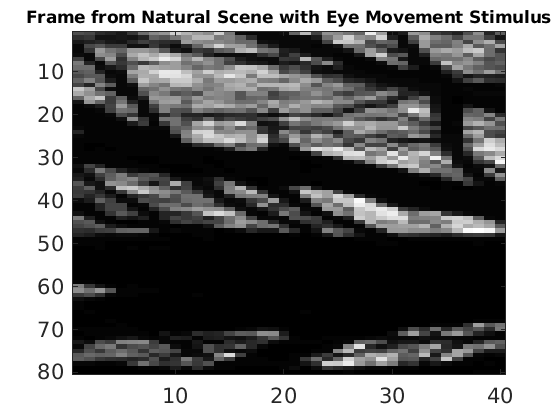

In [52]:
%% Load stimulus movie and fit/spiking data using RemoteDataToolbox

% Loads the appropriate movie and spiking data for the experimental
% conditions.
[testmovie, xval_mosaic] =  loadDataRGCFigure2(experimentI,stimulusTestI,cellTypeI);


% Length of WN movie is 1200, take nFrames to limit natural movie to same length
nFrames = 1200; 
testmovieshort = double(testmovie.matrix(:,:,1:nFrames)); 

figure; imagesc(testmovieshort(:,:,1)); colormap gray;
title('Frame from Natural Scene with Eye Movement Stimulus','fontsize',8); 

In [16]:
%% Upsample movie stimulus for os computation    
frRS = 8;
testmovieRS = zeros(size(testmovieshort,1),size(testmovieshort,2),frRS*size(testmovieshort,3));
for frnum = 1:nFrames
    for frrep = 1:frRS
        testmovieRS(:,:,(frnum-1)*frRS+frrep) = testmovieshort(:,:,frnum);
    end
end

In [19]:
%% Generate display, scene, oi, sensor
paramsStim.nsteps = 1;%nFrames;%size(testmovieshort,3);
paramsStim.timeInterval = 1/125; % sec
paramsStim.expTime = 1/125; % sec

% % For 2013-08-19-6
% r = 12 mm = 36 degs;
% theta = 330 degs;
% side = 'left';
paramsStim.fov = 8;
paramsStim.radius = 36/3;
paramsStim.theta = 330;
paramsStim.side = 'left';

% Generate isetbio scene, oi and cone mosaic with movie
iStim = ieStimulusMovie(testmovieshort(:,:,1:nFrames),paramsStim);
sensor = iStim.sensor;

sensor.data.volts = 5e-4*double(testmovieshort)./255;
sensor = sensorSet(sensor, 'cone type',3*ones([size(testmovieshort,1) size(testmovieshort,2)]));

clear testmovieRS % testmovieshort

Computing cone isomerization:    
[vcReadImage] Assuming 8bit image and 10 bit LUT


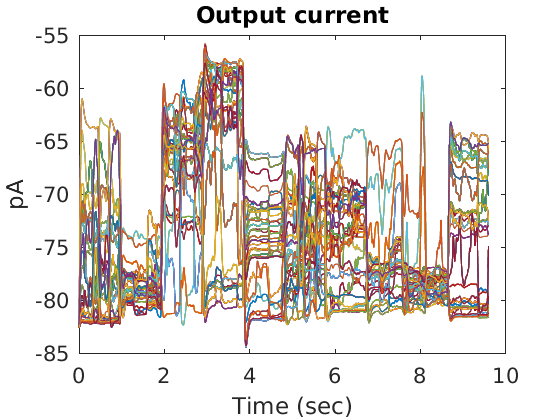

[Warning: The input is a sensor, should update to use coneMosaic.] 
[> In osLinear/osCompute (line 23)
  In pymat_eval (line 31)
  In matlabserver (line 24)] 

ans = 

  Figure (1: ISET GraphWin) with properties:

      Number: 1
        Name: 'ISET GraphWin'
       Color: [1 1 1]
    Position: [0.0070 0.5500 0.2800 0.3600]
       Units: 'normalized'

  Use GET to show all properties


In [53]:
%% Outer segment calculation - linear model
% The iStim structure generates the movie, the scene, the oi and the
% cone absorptions. The next step is to get the outer segment current. The
% linear outer segment model is employed here.

% Initialize
osL = osCreate('linear');
% osL = osSet(osL,'sConeFilter',1);

% Set size of retinal patch based on absorptions sensor object
patchSize = sensorGet(sensor,'width','m');
osL = osSet(osL, 'patch size', patchSize);

% Set time step of simulation equal to absorptions sensor object
timeStep = sensorGet(sensor,'time interval','sec');
osL = osSet(osL, 'time step', timeStep);

% Set circular convolution, only steady state
paramsOSL.convolutionType = 1; 
paramsOSL.ecc = 11; % mm
paramsOSL.singleType = 1;
osLSub = osL;

% Compute the outer segment response to the absorptions with the linear
% model.
osL = osCompute(osL,sensor,paramsOSL);
osPlot(osL,sensor,'type','current')

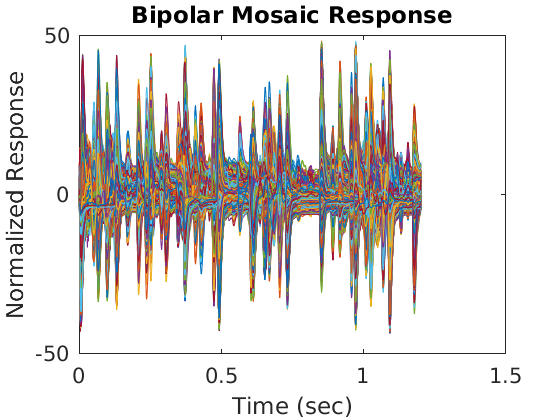

ans = 

  Figure (1: ISET GraphWin) with properties:

      Number: 1
        Name: 'ISET GraphWin'
       Color: [1 1 1]
    Position: [0.0070 0.4000 0.4000 0.5000]
       Units: 'normalized'

  Use GET to show all properties


In [54]:
%% Find bipolar responses

os = osLSub;

bpParams.cellType = 'offDiffuse';
% sets filter as theoretical, mean physiology, or individual phys:
bpParams.filterType = 1; 
% sets linear, on half-wave rectification, or on and off half-wave rect
bpParams.rectifyType = 1;

bp = bipolar(os, bpParams);
bp.bipolarSet('sRFcenter',1);
bp.bipolarSet('sRFcenter',1);

% Need to fix bp compute bc it copies sensor
bp = bipolarCompute(bp, os);

bipolarPlot(bp,'responseCenter')
ylabel('Normalized Response');

In [25]:
%% Build inner retina object
% Set parameters
params.name = 'macaque phys';
params.eyeSide = 'left'; 
params.eyeRadius = 36; 
params.eyeAngle = 0; ntrials = 0;

% Determined at beginning to allow looping
params.experimentID = experimentID; % Experimental dataset
params.stimulusTest = stimulusTest; % WN or NSEM
params.cellType = cellType;         % ON or OFF Parasol;

params.cellIndices = 1:10%:118;

% Create object
innerRetinaSU = irPhys(bp, params);
nTrials = 57; 
innerRetinaSU.mosaic{1} = innerRetinaSU.mosaic{1}.set('numberTrials',nTrials);


params = 

            name: 'macaque phys'
         eyeSide: 'left'
       eyeRadius: 36
        eyeAngle: 0
    experimentID: '2013-08-19-6'
    stimulusTest: 'NSEM'
        cellType: 'On Parasol'
     cellIndices: [1 2 3 4 5 6 7 8 9 10]


In [26]:
%% Compute the inner retina response

% Linear convolution
innerRetinaSU = irCompute(innerRetinaSU, bp); 

innerRetinaSU = irSet(innerRetinaSU,'timing',1/120);

% Get the PSTH from the object
innerRetinaSUPSTH = mosaicGet(innerRetinaSU.mosaic{1},'responsePsth');


Spike Generation:
Elapsed time is 13.844113 seconds.
Elapsed time is 13.923580 seconds.
     
Spike Generation:
Elapsed time is 13.620757 seconds.
Elapsed time is 13.685556 seconds.


In [27]:
%% Generate outer segment object for GLM from RGB scene data

% In this case, the RGC GLM calculation converts from the frame buffer
% values in the movie to the spiking responses.  For this calculation, we
% store the movie stimulus in the the outer segment object 'displayRGB'.

os1 = osCreate('displayRGB'); 
os1 = osSet(os1, 'timeStep', 1/120);

% Attach the movie to the object
os1 = osSet(os1, 'rgbData', double(testmovieshort));

In [28]:
%% Generate RGC object for simulated GLM prediction of response
% Set the parameters for the inner retina RGC mosaic. For the inner retina
% type irPhys, the values for eyeSide, eyeRadius and eyeAngle have no
% effect, because those are dependent on the properties of the retinal
% piece used in the Chichilnisky Lab experiment.

% Set parameters
params.name = 'macaque phys';
params.eyeSide = 'left'; 
params.eyeRadius = 12; 
params.eyeAngle = 0; ntrials = 0;

% Determined at beginning to allow looping
params.experimentID = experimentID; % Experimental dataset
params.stimulusTest = stimulusTest; % WN or NSEM
params.cellType = cellType;         % ON or OFF Parasol

params.cellIndices = 1:10%:118;

% Create object
innerRetina = irPhys(os1, params);
nTrials = 57;
innerRetina.mosaic{1} = innerRetina.mosaic{1}.set('numberTrials',nTrials);

params = 

            name: 'macaque phys'
         eyeSide: 'left'
       eyeRadius: 12
        eyeAngle: 0
    experimentID: '2013-08-19-6'
    stimulusTest: 'NSEM'
        cellType: 'On Parasol'
     cellIndices: [1 2 3 4 5 6 7 8 9 10]


In [29]:
%% Compute the inner retina response

innerRetina = irCompute(innerRetina, os1);

% Get the PSTH from the object
innerRetinaPSTH = mosaicGet(innerRetina.mosaic{1},'responsePsth');

Spike Generation:
Elapsed time is 13.757622 seconds.
Elapsed time is 13.809832 seconds.
     
Spike Generation:
Elapsed time is 13.562089 seconds.
Elapsed time is 13.621105 seconds.


In [30]:
%% Create a new inner retina object and attach the recorded spikes
% We also want to compare the spikes recorded in the experiment to those
% from the simulation. We create a separate inner retina object with
% isetbio to store these spikes. This makes it easy to use isetbio to plot
% aspects of the response.

% Create the object.
innerRetinaRecorded = irPhys(os1, params);  

% innerRetinaRecorded = irSet(innerRetinaRecorded,'timing',.008);
innerRetinaRecorded.mosaic{1} = innerRetinaRecorded.mosaic{1}.set('numberTrials',nTrials);

% Set the recorded spikes that we got from the RDT into the object.
innerRetinaRecorded = irSet(innerRetinaRecorded,'recordedSpikes',xval_mosaic);
% Get the PSTH using an isetbio routine.
innerRetinaRecordedPSTH = mosaicGet(innerRetinaRecorded.mosaic{1},'responsePsth');


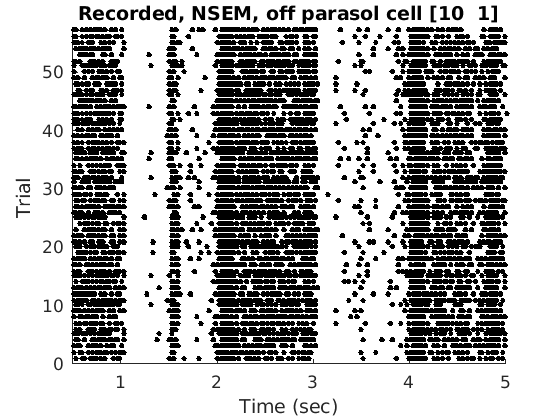

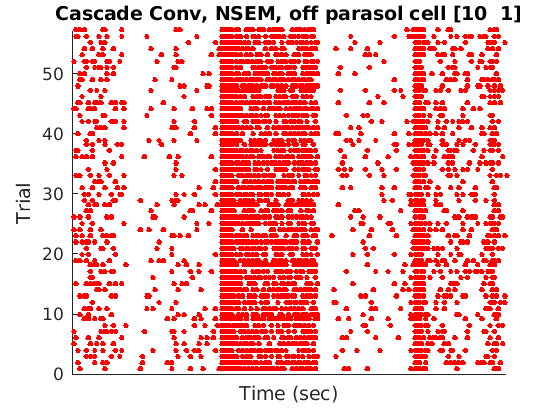

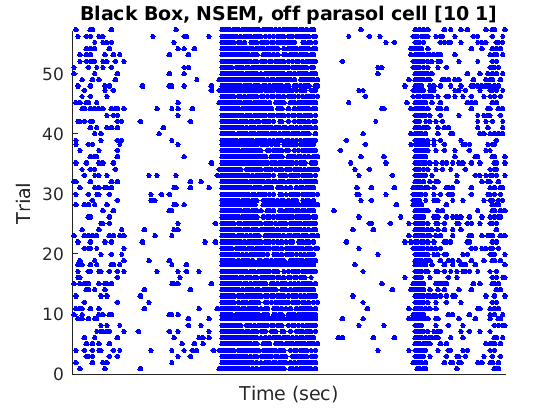

In [39]:
%% Plot the rasters

% Set the time and cell number
tStart = 1.5;% 9%1.5;
tEnd = 6;%21;%18%21;%1*8.5;
cellNum = 10;

nTrialsShow = nTrials;

% Plot the original GLM prediction
% vcNewGraphWin([],'upperleftbig'); 
h1 = figure; hold on;
% subplot(312); hold on;
% subplot(211); hold on;
% irPlot(innerRetina,'raster','cell',[cellNum 1],'hold','on','color','r')
irPlot(innerRetinaSU,'raster','cell',[cellNum 1],'hf',h1,'dt',0.1,'color','b');
title(sprintf('Black Box, NSEM, off parasol cell [%d 1]',cellNum));
set(gca,'fontsize',8);
axis([tStart tEnd 0 nTrialsShow]);
% axis off
set(gca, 'xtick',-1);

% Plot the biophys/subunit prediction
h2 = figure;
% subplot(313); hold on;
irPlot(innerRetina,'raster','cell',[cellNum 1],'hf',h2,'dt',0.1,'color','r');
title(sprintf('Cascade Conv, NSEM, off parasol cell [%d  1]',cellNum));
set(gca,'fontsize',8);
axis([tStart tEnd 0 nTrials]);
set(gca, 'xtick',-1);

% % Plot the recorded spikes
% subplot(311); hold on;
h3 = figure;
irPlot(innerRetinaRecorded,'raster','cell',[cellNum 1],'hf',h3,'dt',0.1,'color','k');
title(sprintf('Recorded, NSEM, off parasol cell [%d  1]',cellNum));
set(gca,'fontsize',8);

switch stimulusTestI
    case 1
        axis([tStart-0.5 tEnd-0.5 0 nTrials]);
    case 2
        axis([tStart-1 tEnd-1 0 nTrials]);
end


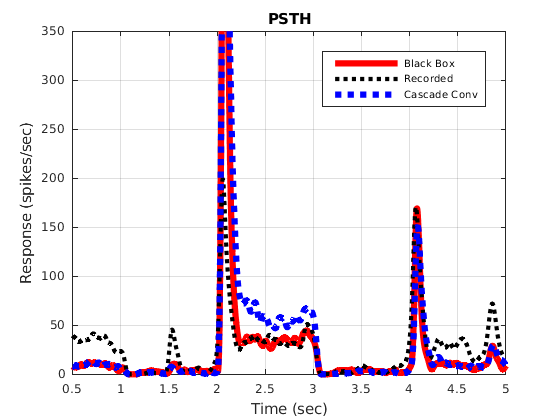

In [49]:
% Plot the PSTHs

figure;
minlen = min([length(innerRetinaPSTH{cellNum}) length(innerRetinaRecordedPSTH{cellNum}) length(innerRetinaSUPSTH{cellNum}) ]);
hold off

del1 = 1200; del2 = 600;
switch stimulusTestI
    case 1
        plot(([1:minlen-del1])./del1, innerRetinaPSTH{cellNum}(del2+(1:minlen-del1)),'r','linewidth',3);
        hold on;
        plot([1:minlen-del1]./del1,innerRetinaRecordedPSTH{cellNum}(((1:minlen-del1))),':k','linewidth',2);
        plot([1:minlen-del1]./del1, innerRetinaSUPSTH{cellNum}(del2+(1:minlen-del1)),':b','linewidth',3);
        
        ax3 = axis;
        axis([0 8.5 ax3(3) ax3(4)])

    case 2
   
        plot(([1:minlen-del1])./del1, innerRetinaPSTH{cellNum}(del1+(1:minlen-del1)),'r','linewidth',3);
        hold on;
        plot([1:minlen-del1]./del1,innerRetinaRecordedPSTH{cellNum}(((1:minlen-del1))),':k','linewidth',2);
        hold on;
        plot(([1:minlen-del1])./del1, innerRetinaSUPSTH{cellNum}(del1+(1:minlen-del1)),':b','linewidth',3);
        
        
        ax3 = axis;
        axis([tStart-1 tEnd-1 ax3(3) ax3(4)/2])
end
title('PSTH')
legend('Black Box','Recorded','Cascade Conv');
grid on
set(gca,'fontsize',6);
xlabel('Time (sec)'); ylabel('Response (spikes/sec)');